In [25]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, RocCurveDisplay, brier_score_loss, precision_score, recall_score, f1_score
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb
import shap 

In [3]:
# ===== 1. ĐỌC DỮ LIỆU =====
df = pd.read_excel("hmeq.xlsx", sheet_name=0, engine="openpyxl")
df.drop(columns=['gDEBTINC'], inplace=True)

c:\Users\CPN\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\worksheet\header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [6]:
# Các biến cần flag missing
miss_vars = ['DEBTINC', 'VALUE', 'DEROG', 'JOB', 'DELINQ', 'YOJ', 'NINQ', 'CLAGE']
for var in miss_vars:
    flag_col = f"{var}_missing"
    df[flag_col] = df[var].isna().astype(int)

# Không impute, XGBoost tự xử lý missing

In [7]:
# ===== 2. Khai báo biến =====
target_variable = 'BAD'
numerical_cols = ['BAD','LOAN','MORTDUE','VALUE','YOJ','DEROG','DELINQ','CLAGE','NINQ','CLNO','DEBTINC']
categorical_cols = ['REASON','JOB']

In [12]:
# Chuyển các biến categorical sang dtype 'category' để XGBoost hỗ trợ
cat_vars = ['REASON', 'JOB']
for var in cat_vars:
    df[var] = df[var].astype('category')

In [9]:
# 2. Khai báo biến
target = 'BAD'
features = [c for c in df.columns if c != target]

In [13]:
# 3. Split dữ liệu
X_train, X_test, y_train, y_test = train_test_split(
    df[features], df[target], test_size=0.2, random_state=42, stratify=df[target]
)

In [17]:
# 4. Cấu hình Optuna để in progress và chỉ định minimize vì logloss càng nhỏ càng tốt
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction='minimize')

[I 2025-06-20 11:39:57,913] A new study created in memory with name: no-name-4fec853c-71f3-433c-bdcb-027df6c69aff


In [19]:
# 5. Xây dựng Optuna tuner sử dụng logloss
def objective(trial):
    params = {
        'objective': 'binary:logistic',  # tương đương entropy loss
        'eval_metric': 'logloss',
        'tree_method': 'hist',
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10, log=True),
        'lambda': trial.suggest_float('lambda', 1e-3, 10, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10, log=True),
    }
    print(f"Trial {trial.number} params: {params}")

    dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
    cv = xgb.cv(
        params=params,
        dtrain=dtrain,
        num_boost_round=1000,
        nfold=5,
        early_stopping_rounds=50,
        seed=42,
        metrics=('logloss'),
        as_pandas=True,
    )
    trial.set_user_attr('best_iteration', len(cv))
    # Trả về giá trị logloss nhỏ nhất
    return cv['test-logloss-mean'].min()

study.optimize(objective, n_trials=100)

Trial 0 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0014921000440092755, 'max_depth': 10, 'subsample': 0.7463392705184753, 'colsample_bytree': 0.5395217723905499, 'min_child_weight': 0.14224472024401202, 'lambda': 0.06350298313591343, 'alpha': 0.16628534439524498}


[I 2025-06-20 11:40:54,162] Trial 0 finished with value: 0.26758352705476923 and parameters: {'learning_rate': 0.0014921000440092755, 'max_depth': 10, 'subsample': 0.7463392705184753, 'colsample_bytree': 0.5395217723905499, 'min_child_weight': 0.14224472024401202, 'lambda': 0.06350298313591343, 'alpha': 0.16628534439524498}. Best is trial 0 with value: 0.26758352705476923.


Trial 1 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0012196069376894944, 'max_depth': 9, 'subsample': 0.6693551333816619, 'colsample_bytree': 0.8885098649544816, 'min_child_weight': 0.0544017829327285, 'lambda': 0.16263811371520023, 'alpha': 0.0017363124642270356}


[I 2025-06-20 11:41:26,885] Trial 1 finished with value: 0.2820409162636489 and parameters: {'learning_rate': 0.0012196069376894944, 'max_depth': 9, 'subsample': 0.6693551333816619, 'colsample_bytree': 0.8885098649544816, 'min_child_weight': 0.0544017829327285, 'lambda': 0.16263811371520023, 'alpha': 0.0017363124642270356}. Best is trial 0 with value: 0.26758352705476923.


Trial 2 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0200435015518249, 'max_depth': 4, 'subsample': 0.9525345047888623, 'colsample_bytree': 0.6238248353377298, 'min_child_weight': 0.004424480687574457, 'lambda': 0.00458871249071957, 'alpha': 0.011195885298536759}


[I 2025-06-20 11:41:37,164] Trial 2 finished with value: 0.18653755975538994 and parameters: {'learning_rate': 0.0200435015518249, 'max_depth': 4, 'subsample': 0.9525345047888623, 'colsample_bytree': 0.6238248353377298, 'min_child_weight': 0.004424480687574457, 'lambda': 0.00458871249071957, 'alpha': 0.011195885298536759}. Best is trial 2 with value: 0.18653755975538994.


Trial 3 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.002147594269685601, 'max_depth': 4, 'subsample': 0.8099335155285257, 'colsample_bytree': 0.811246944836544, 'min_child_weight': 0.27285685643576274, 'lambda': 7.502875827336541, 'alpha': 0.001315034993552967}


[I 2025-06-20 11:41:47,826] Trial 3 finished with value: 0.295100959885628 and parameters: {'learning_rate': 0.002147594269685601, 'max_depth': 4, 'subsample': 0.8099335155285257, 'colsample_bytree': 0.811246944836544, 'min_child_weight': 0.27285685643576274, 'lambda': 7.502875827336541, 'alpha': 0.001315034993552967}. Best is trial 2 with value: 0.18653755975538994.


Trial 4 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.08708524888218963, 'max_depth': 7, 'subsample': 0.8202188399362286, 'colsample_bytree': 0.9809254395828106, 'min_child_weight': 0.04175022059709952, 'lambda': 0.02818418615721768, 'alpha': 0.03531100871857754}


[I 2025-06-20 11:41:52,108] Trial 4 finished with value: 0.18382587448941398 and parameters: {'learning_rate': 0.08708524888218963, 'max_depth': 7, 'subsample': 0.8202188399362286, 'colsample_bytree': 0.9809254395828106, 'min_child_weight': 0.04175022059709952, 'lambda': 0.02818418615721768, 'alpha': 0.03531100871857754}. Best is trial 4 with value: 0.18382587448941398.


Trial 5 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0698077207334417, 'max_depth': 7, 'subsample': 0.5146280269464837, 'colsample_bytree': 0.9034999433722941, 'min_child_weight': 0.0011830304238475563, 'lambda': 7.8804362531571215, 'alpha': 0.0035593885074096145}


[I 2025-06-20 11:42:09,655] Trial 5 finished with value: 0.17194291073635806 and parameters: {'learning_rate': 0.0698077207334417, 'max_depth': 7, 'subsample': 0.5146280269464837, 'colsample_bytree': 0.9034999433722941, 'min_child_weight': 0.0011830304238475563, 'lambda': 7.8804362531571215, 'alpha': 0.0035593885074096145}. Best is trial 5 with value: 0.17194291073635806.


Trial 6 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.2886794344095228, 'max_depth': 4, 'subsample': 0.7414280780659644, 'colsample_bytree': 0.6651953922140017, 'min_child_weight': 0.0038045221591369947, 'lambda': 0.0010339077701544315, 'alpha': 0.09184583914693803}


[I 2025-06-20 11:42:11,801] Trial 6 finished with value: 0.19412855436712556 and parameters: {'learning_rate': 0.2886794344095228, 'max_depth': 4, 'subsample': 0.7414280780659644, 'colsample_bytree': 0.6651953922140017, 'min_child_weight': 0.0038045221591369947, 'lambda': 0.0010339077701544315, 'alpha': 0.09184583914693803}. Best is trial 5 with value: 0.17194291073635806.


Trial 7 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.016045101804423905, 'max_depth': 8, 'subsample': 0.7461088932685074, 'colsample_bytree': 0.7390769461706836, 'min_child_weight': 0.006481733179866045, 'lambda': 0.26820209885954155, 'alpha': 0.001328657109410185}


[I 2025-06-20 11:42:34,316] Trial 7 finished with value: 0.17296240334390275 and parameters: {'learning_rate': 0.016045101804423905, 'max_depth': 8, 'subsample': 0.7461088932685074, 'colsample_bytree': 0.7390769461706836, 'min_child_weight': 0.006481733179866045, 'lambda': 0.26820209885954155, 'alpha': 0.001328657109410185}. Best is trial 5 with value: 0.17194291073635806.


Trial 8 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.017657492160006734, 'max_depth': 7, 'subsample': 0.934899994240687, 'colsample_bytree': 0.58014309388453, 'min_child_weight': 0.04327381600321942, 'lambda': 0.002343910940614598, 'alpha': 0.003444461354866866}


[I 2025-06-20 11:42:48,675] Trial 8 finished with value: 0.174038159449775 and parameters: {'learning_rate': 0.017657492160006734, 'max_depth': 7, 'subsample': 0.934899994240687, 'colsample_bytree': 0.58014309388453, 'min_child_weight': 0.04327381600321942, 'lambda': 0.002343910940614598, 'alpha': 0.003444461354866866}. Best is trial 5 with value: 0.17194291073635806.


Trial 9 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.03376201374654515, 'max_depth': 9, 'subsample': 0.8280743116616183, 'colsample_bytree': 0.8490520883016694, 'min_child_weight': 9.480272489665708, 'lambda': 0.04735034809789758, 'alpha': 0.0013714580178853012}


[I 2025-06-20 11:43:02,358] Trial 9 finished with value: 0.19201395350273617 and parameters: {'learning_rate': 0.03376201374654515, 'max_depth': 9, 'subsample': 0.8280743116616183, 'colsample_bytree': 0.8490520883016694, 'min_child_weight': 9.480272489665708, 'lambda': 0.04735034809789758, 'alpha': 0.0013714580178853012}. Best is trial 5 with value: 0.17194291073635806.


Trial 10 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.005063784333529247, 'max_depth': 6, 'subsample': 0.5169772430458511, 'colsample_bytree': 0.9826661480520766, 'min_child_weight': 0.001110777806193744, 'lambda': 8.11485011498479, 'alpha': 3.6528015492566763}


[I 2025-06-20 11:43:19,473] Trial 10 finished with value: 0.25667841790643525 and parameters: {'learning_rate': 0.005063784333529247, 'max_depth': 6, 'subsample': 0.5169772430458511, 'colsample_bytree': 0.9826661480520766, 'min_child_weight': 0.001110777806193744, 'lambda': 8.11485011498479, 'alpha': 3.6528015492566763}. Best is trial 5 with value: 0.17194291073635806.


Trial 11 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0771381800934965, 'max_depth': 6, 'subsample': 0.5148183548299806, 'colsample_bytree': 0.7181988559863725, 'min_child_weight': 0.0010081333504705608, 'lambda': 0.7191542590009414, 'alpha': 0.010858086573241027}


[I 2025-06-20 11:43:25,225] Trial 11 finished with value: 0.1772688096816541 and parameters: {'learning_rate': 0.0771381800934965, 'max_depth': 6, 'subsample': 0.5148183548299806, 'colsample_bytree': 0.7181988559863725, 'min_child_weight': 0.0010081333504705608, 'lambda': 0.7191542590009414, 'alpha': 0.010858086573241027}. Best is trial 5 with value: 0.17194291073635806.


Trial 12 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0064650411301049645, 'max_depth': 8, 'subsample': 0.6193579480021896, 'colsample_bytree': 0.761084134919013, 'min_child_weight': 0.007152849172547787, 'lambda': 1.0604786906125574, 'alpha': 0.7067039060832293}


[I 2025-06-20 11:43:49,360] Trial 12 finished with value: 0.2009037877079422 and parameters: {'learning_rate': 0.0064650411301049645, 'max_depth': 8, 'subsample': 0.6193579480021896, 'colsample_bytree': 0.761084134919013, 'min_child_weight': 0.007152849172547787, 'lambda': 1.0604786906125574, 'alpha': 0.7067039060832293}. Best is trial 5 with value: 0.17194291073635806.


Trial 13 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.06277785865457082, 'max_depth': 8, 'subsample': 0.6000460887366927, 'colsample_bytree': 0.9075054948265224, 'min_child_weight': 0.018906690741554388, 'lambda': 1.5528191540194294, 'alpha': 0.009253771577956845}


[I 2025-06-20 11:44:00,565] Trial 13 finished with value: 0.17514424200148457 and parameters: {'learning_rate': 0.06277785865457082, 'max_depth': 8, 'subsample': 0.6000460887366927, 'colsample_bytree': 0.9075054948265224, 'min_child_weight': 0.018906690741554388, 'lambda': 1.5528191540194294, 'alpha': 0.009253771577956845}. Best is trial 5 with value: 0.17194291073635806.


Trial 14 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.20450714161339587, 'max_depth': 5, 'subsample': 0.6646958852504752, 'colsample_bytree': 0.7656310246448119, 'min_child_weight': 1.0319764710120487, 'lambda': 0.29948861572099417, 'alpha': 0.006837892710564308}


[I 2025-06-20 11:44:03,093] Trial 14 finished with value: 0.18809687718711982 and parameters: {'learning_rate': 0.20450714161339587, 'max_depth': 5, 'subsample': 0.6646958852504752, 'colsample_bytree': 0.7656310246448119, 'min_child_weight': 1.0319764710120487, 'lambda': 0.29948861572099417, 'alpha': 0.006837892710564308}. Best is trial 5 with value: 0.17194291073635806.


Trial 15 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.007476826187532741, 'max_depth': 8, 'subsample': 0.886706732371903, 'colsample_bytree': 0.7106920562269734, 'min_child_weight': 0.008872489001708747, 'lambda': 0.012394699888219151, 'alpha': 0.026169566905494865}


[I 2025-06-20 11:44:28,288] Trial 15 finished with value: 0.1867135306358977 and parameters: {'learning_rate': 0.007476826187532741, 'max_depth': 8, 'subsample': 0.886706732371903, 'colsample_bytree': 0.7106920562269734, 'min_child_weight': 0.008872489001708747, 'lambda': 0.012394699888219151, 'alpha': 0.026169566905494865}. Best is trial 5 with value: 0.17194291073635806.


Trial 16 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.03410866491563578, 'max_depth': 10, 'subsample': 0.5827405629238397, 'colsample_bytree': 0.9284390297747569, 'min_child_weight': 0.0028740850902376305, 'lambda': 3.145673864901603, 'alpha': 0.003242157999439285}


[I 2025-06-20 11:44:59,170] Trial 16 finished with value: 0.17372122844433707 and parameters: {'learning_rate': 0.03410866491563578, 'max_depth': 10, 'subsample': 0.5827405629238397, 'colsample_bytree': 0.9284390297747569, 'min_child_weight': 0.0028740850902376305, 'lambda': 3.145673864901603, 'alpha': 0.003242157999439285}. Best is trial 5 with value: 0.17194291073635806.


Trial 17 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.1281861094254797, 'max_depth': 6, 'subsample': 0.692582695332691, 'colsample_bytree': 0.8181017039006651, 'min_child_weight': 0.015292592948926475, 'lambda': 0.36764100156509694, 'alpha': 7.189544068298622}


[I 2025-06-20 11:45:08,068] Trial 17 finished with value: 0.1962848892411116 and parameters: {'learning_rate': 0.1281861094254797, 'max_depth': 6, 'subsample': 0.692582695332691, 'colsample_bytree': 0.8181017039006651, 'min_child_weight': 0.015292592948926475, 'lambda': 0.36764100156509694, 'alpha': 7.189544068298622}. Best is trial 5 with value: 0.17194291073635806.


Trial 18 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.01045130327724994, 'max_depth': 3, 'subsample': 0.5675270977734562, 'colsample_bytree': 0.6611167656360947, 'min_child_weight': 0.0020263263544347283, 'lambda': 3.535918614793149, 'alpha': 0.3074093171373901}


[I 2025-06-20 11:45:17,458] Trial 18 finished with value: 0.23894922163536939 and parameters: {'learning_rate': 0.01045130327724994, 'max_depth': 3, 'subsample': 0.5675270977734562, 'colsample_bytree': 0.6611167656360947, 'min_child_weight': 0.0020263263544347283, 'lambda': 3.535918614793149, 'alpha': 0.3074093171373901}. Best is trial 5 with value: 0.17194291073635806.


Trial 19 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.043939802018383184, 'max_depth': 9, 'subsample': 0.988542178541674, 'colsample_bytree': 0.8465853475079125, 'min_child_weight': 0.4339995991600418, 'lambda': 0.13639539250337862, 'alpha': 0.037182539079811075}


[I 2025-06-20 11:45:23,989] Trial 19 finished with value: 0.2000503853576534 and parameters: {'learning_rate': 0.043939802018383184, 'max_depth': 9, 'subsample': 0.988542178541674, 'colsample_bytree': 0.8465853475079125, 'min_child_weight': 0.4339995991600418, 'lambda': 0.13639539250337862, 'alpha': 0.037182539079811075}. Best is trial 5 with value: 0.17194291073635806.


Trial 20 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.003512029456328174, 'max_depth': 7, 'subsample': 0.8692153537596486, 'colsample_bytree': 0.5040607396337, 'min_child_weight': 0.01676345282455433, 'lambda': 2.3176411966986854, 'alpha': 0.003961990220396913}


[I 2025-06-20 11:45:42,942] Trial 20 finished with value: 0.2391927233355348 and parameters: {'learning_rate': 0.003512029456328174, 'max_depth': 7, 'subsample': 0.8692153537596486, 'colsample_bytree': 0.5040607396337, 'min_child_weight': 0.01676345282455433, 'lambda': 2.3176411966986854, 'alpha': 0.003961990220396913}. Best is trial 5 with value: 0.17194291073635806.


Trial 21 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.030452367786624183, 'max_depth': 10, 'subsample': 0.559363560381085, 'colsample_bytree': 0.9398173788870153, 'min_child_weight': 0.0025213615304941826, 'lambda': 3.921234215244028, 'alpha': 0.0033170995600344533}


[I 2025-06-20 11:46:23,672] Trial 21 finished with value: 0.17252677978140582 and parameters: {'learning_rate': 0.030452367786624183, 'max_depth': 10, 'subsample': 0.559363560381085, 'colsample_bytree': 0.9398173788870153, 'min_child_weight': 0.0025213615304941826, 'lambda': 3.921234215244028, 'alpha': 0.0033170995600344533}. Best is trial 5 with value: 0.17194291073635806.


Trial 22 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.02382645861207773, 'max_depth': 10, 'subsample': 0.546242837233085, 'colsample_bytree': 0.950467341814524, 'min_child_weight': 0.0019061007837000606, 'lambda': 8.759956509666294, 'alpha': 0.0012404721521962014}


[I 2025-06-20 11:47:04,122] Trial 22 finished with value: 0.17610050808240807 and parameters: {'learning_rate': 0.02382645861207773, 'max_depth': 10, 'subsample': 0.546242837233085, 'colsample_bytree': 0.950467341814524, 'min_child_weight': 0.0019061007837000606, 'lambda': 8.759956509666294, 'alpha': 0.0012404721521962014}. Best is trial 5 with value: 0.17194291073635806.


Trial 23 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.011569947490356808, 'max_depth': 8, 'subsample': 0.5006197329852474, 'colsample_bytree': 0.8792803021925952, 'min_child_weight': 0.006405924618556038, 'lambda': 0.5609467297944721, 'alpha': 0.003155341693762551}


[I 2025-06-20 11:47:33,541] Trial 23 finished with value: 0.18346826733628535 and parameters: {'learning_rate': 0.011569947490356808, 'max_depth': 8, 'subsample': 0.5006197329852474, 'colsample_bytree': 0.8792803021925952, 'min_child_weight': 0.006405924618556038, 'lambda': 0.5609467297944721, 'alpha': 0.003155341693762551}. Best is trial 5 with value: 0.17194291073635806.


Trial 24 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.05048139394914687, 'max_depth': 9, 'subsample': 0.6354390421496965, 'colsample_bytree': 0.9960076296421236, 'min_child_weight': 0.0015316424072426484, 'lambda': 1.6410708823824147, 'alpha': 0.015237708980922925}


[I 2025-06-20 11:47:50,255] Trial 24 finished with value: 0.17605901506982474 and parameters: {'learning_rate': 0.05048139394914687, 'max_depth': 9, 'subsample': 0.6354390421496965, 'colsample_bytree': 0.9960076296421236, 'min_child_weight': 0.0015316424072426484, 'lambda': 1.6410708823824147, 'alpha': 0.015237708980922925}. Best is trial 5 with value: 0.17194291073635806.


Trial 25 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.012835406889849299, 'max_depth': 7, 'subsample': 0.5438425523355823, 'colsample_bytree': 0.7970488544855483, 'min_child_weight': 0.002503453104440837, 'lambda': 3.7558783181278987, 'alpha': 0.005459196191791299}


[I 2025-06-20 11:48:12,025] Trial 25 finished with value: 0.18495940765741245 and parameters: {'learning_rate': 0.012835406889849299, 'max_depth': 7, 'subsample': 0.5438425523355823, 'colsample_bytree': 0.7970488544855483, 'min_child_weight': 0.002503453104440837, 'lambda': 3.7558783181278987, 'alpha': 0.005459196191791299}. Best is trial 5 with value: 0.17194291073635806.


Trial 26 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.14812878227002152, 'max_depth': 5, 'subsample': 0.688569617325073, 'colsample_bytree': 0.9376150370177387, 'min_child_weight': 0.010576941835260232, 'lambda': 5.002281779458638, 'alpha': 0.002195719501614699}


[I 2025-06-20 11:48:17,156] Trial 26 finished with value: 0.1771431114699023 and parameters: {'learning_rate': 0.14812878227002152, 'max_depth': 5, 'subsample': 0.688569617325073, 'colsample_bytree': 0.9376150370177387, 'min_child_weight': 0.010576941835260232, 'lambda': 5.002281779458638, 'alpha': 0.002195719501614699}. Best is trial 5 with value: 0.17194291073635806.


Trial 27 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.027780705697830227, 'max_depth': 8, 'subsample': 0.7832802465085003, 'colsample_bytree': 0.8599016916692505, 'min_child_weight': 0.0044676939390312755, 'lambda': 0.30379585006691406, 'alpha': 0.01758394409501605}


[I 2025-06-20 11:48:30,653] Trial 27 finished with value: 0.17583203670128822 and parameters: {'learning_rate': 0.027780705697830227, 'max_depth': 8, 'subsample': 0.7832802465085003, 'colsample_bytree': 0.8599016916692505, 'min_child_weight': 0.0044676939390312755, 'lambda': 0.30379585006691406, 'alpha': 0.01758394409501605}. Best is trial 5 with value: 0.17194291073635806.


Trial 28 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.04300518066470426, 'max_depth': 10, 'subsample': 0.7156400089686472, 'colsample_bytree': 0.730343172646766, 'min_child_weight': 3.4085337746461217, 'lambda': 1.0223595205251346, 'alpha': 0.051471793004131246}


[I 2025-06-20 11:48:40,384] Trial 28 finished with value: 0.18288652610408246 and parameters: {'learning_rate': 0.04300518066470426, 'max_depth': 10, 'subsample': 0.7156400089686472, 'colsample_bytree': 0.730343172646766, 'min_child_weight': 3.4085337746461217, 'lambda': 1.0223595205251346, 'alpha': 0.051471793004131246}. Best is trial 5 with value: 0.17194291073635806.


Trial 29 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.08166255897236274, 'max_depth': 10, 'subsample': 0.6354200823868729, 'colsample_bytree': 0.7890744988557999, 'min_child_weight': 0.10234112106565445, 'lambda': 0.0701193263238389, 'alpha': 0.19166146960001737}


[I 2025-06-20 11:48:46,187] Trial 29 finished with value: 0.19230963135605936 and parameters: {'learning_rate': 0.08166255897236274, 'max_depth': 10, 'subsample': 0.6354200823868729, 'colsample_bytree': 0.7890744988557999, 'min_child_weight': 0.10234112106565445, 'lambda': 0.0701193263238389, 'alpha': 0.19166146960001737}. Best is trial 5 with value: 0.17194291073635806.


Trial 30 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.01649750144872978, 'max_depth': 9, 'subsample': 0.7466642574530663, 'colsample_bytree': 0.6822483847783295, 'min_child_weight': 0.02503280802154738, 'lambda': 0.019198302694486313, 'alpha': 0.7778795552790578}


[I 2025-06-20 11:49:06,649] Trial 30 finished with value: 0.18152710095654276 and parameters: {'learning_rate': 0.01649750144872978, 'max_depth': 9, 'subsample': 0.7466642574530663, 'colsample_bytree': 0.6822483847783295, 'min_child_weight': 0.02503280802154738, 'lambda': 0.019198302694486313, 'alpha': 0.7778795552790578}. Best is trial 5 with value: 0.17194291073635806.


Trial 31 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.033371705621405255, 'max_depth': 10, 'subsample': 0.5805695496929948, 'colsample_bytree': 0.9262481600458731, 'min_child_weight': 0.0030203367210986124, 'lambda': 2.9983385760854366, 'alpha': 0.0024276846668687345}


[I 2025-06-20 11:49:37,853] Trial 31 finished with value: 0.1748433530170472 and parameters: {'learning_rate': 0.033371705621405255, 'max_depth': 10, 'subsample': 0.5805695496929948, 'colsample_bytree': 0.9262481600458731, 'min_child_weight': 0.0030203367210986124, 'lambda': 2.9983385760854366, 'alpha': 0.0024276846668687345}. Best is trial 5 with value: 0.17194291073635806.


Trial 32 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.1183830136168949, 'max_depth': 10, 'subsample': 0.5466532872530983, 'colsample_bytree': 0.9466296381185026, 'min_child_weight': 0.001990136587782773, 'lambda': 5.1914831547368365, 'alpha': 0.005291653056148835}


[I 2025-06-20 11:49:53,649] Trial 32 finished with value: 0.17656634554507428 and parameters: {'learning_rate': 0.1183830136168949, 'max_depth': 10, 'subsample': 0.5466532872530983, 'colsample_bytree': 0.9466296381185026, 'min_child_weight': 0.001990136587782773, 'lambda': 5.1914831547368365, 'alpha': 0.005291653056148835}. Best is trial 5 with value: 0.17194291073635806.


Trial 33 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.02443573419427972, 'max_depth': 9, 'subsample': 0.5923993267110976, 'colsample_bytree': 0.9107629461522238, 'min_child_weight': 0.004758839200979005, 'lambda': 1.806671213650447, 'alpha': 0.0010447942826815669}


[I 2025-06-20 11:50:21,925] Trial 33 finished with value: 0.17465206245255066 and parameters: {'learning_rate': 0.02443573419427972, 'max_depth': 9, 'subsample': 0.5923993267110976, 'colsample_bytree': 0.9107629461522238, 'min_child_weight': 0.004758839200979005, 'lambda': 1.806671213650447, 'alpha': 0.0010447942826815669}. Best is trial 5 with value: 0.17194291073635806.


Trial 34 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.05511267197869078, 'max_depth': 9, 'subsample': 0.5663177845101045, 'colsample_bytree': 0.8760049345701183, 'min_child_weight': 0.0010110529368014918, 'lambda': 9.561881200913712, 'alpha': 0.001987926861731724}


[I 2025-06-20 11:50:51,983] Trial 34 finished with value: 0.16824930445641237 and parameters: {'learning_rate': 0.05511267197869078, 'max_depth': 9, 'subsample': 0.5663177845101045, 'colsample_bytree': 0.8760049345701183, 'min_child_weight': 0.0010110529368014918, 'lambda': 9.561881200913712, 'alpha': 0.001987926861731724}. Best is trial 34 with value: 0.16824930445641237.


Trial 35 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.05655249867486152, 'max_depth': 9, 'subsample': 0.6579959483502975, 'colsample_bytree': 0.8860815115231976, 'min_child_weight': 0.0014839057297204126, 'lambda': 5.96897888533091, 'alpha': 0.002005693157127915}


[I 2025-06-20 11:51:12,978] Trial 35 finished with value: 0.17043547800236325 and parameters: {'learning_rate': 0.05655249867486152, 'max_depth': 9, 'subsample': 0.6579959483502975, 'colsample_bytree': 0.8860815115231976, 'min_child_weight': 0.0014839057297204126, 'lambda': 5.96897888533091, 'alpha': 0.002005693157127915}. Best is trial 34 with value: 0.16824930445641237.


Trial 36 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.057366176347709304, 'max_depth': 9, 'subsample': 0.6610027373944949, 'colsample_bytree': 0.8736778422565419, 'min_child_weight': 0.0015934393939834245, 'lambda': 9.837769369971415, 'alpha': 0.0021999694325815712}


[I 2025-06-20 11:51:41,221] Trial 36 finished with value: 0.16979066732876605 and parameters: {'learning_rate': 0.057366176347709304, 'max_depth': 9, 'subsample': 0.6610027373944949, 'colsample_bytree': 0.8736778422565419, 'min_child_weight': 0.0015934393939834245, 'lambda': 9.837769369971415, 'alpha': 0.0021999694325815712}. Best is trial 34 with value: 0.16824930445641237.


Trial 37 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.10260779538386536, 'max_depth': 9, 'subsample': 0.6553783983422047, 'colsample_bytree': 0.8815052693984621, 'min_child_weight': 0.0010353195563955887, 'lambda': 9.493589010466732, 'alpha': 0.001962895135825835}


[I 2025-06-20 11:51:54,967] Trial 37 finished with value: 0.16926252766691413 and parameters: {'learning_rate': 0.10260779538386536, 'max_depth': 9, 'subsample': 0.6553783983422047, 'colsample_bytree': 0.8815052693984621, 'min_child_weight': 0.0010353195563955887, 'lambda': 9.493589010466732, 'alpha': 0.001962895135825835}. Best is trial 34 with value: 0.16824930445641237.


Trial 38 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.10338072169908231, 'max_depth': 9, 'subsample': 0.6702126580088519, 'colsample_bytree': 0.874852696720335, 'min_child_weight': 0.0010044022907871241, 'lambda': 9.362686542580956, 'alpha': 0.002172012753197911}


[I 2025-06-20 11:52:08,919] Trial 38 finished with value: 0.17127203719839695 and parameters: {'learning_rate': 0.10338072169908231, 'max_depth': 9, 'subsample': 0.6702126580088519, 'colsample_bytree': 0.874852696720335, 'min_child_weight': 0.0010044022907871241, 'lambda': 9.362686542580956, 'alpha': 0.002172012753197911}. Best is trial 34 with value: 0.16824930445641237.


Trial 39 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.20742410931024033, 'max_depth': 9, 'subsample': 0.6409607046653308, 'colsample_bytree': 0.8238603444399861, 'min_child_weight': 0.19093257955426385, 'lambda': 5.787956356474893, 'alpha': 0.007504185054934098}


[I 2025-06-20 11:52:14,895] Trial 39 finished with value: 0.17931292440376526 and parameters: {'learning_rate': 0.20742410931024033, 'max_depth': 9, 'subsample': 0.6409607046653308, 'colsample_bytree': 0.8238603444399861, 'min_child_weight': 0.19093257955426385, 'lambda': 5.787956356474893, 'alpha': 0.007504185054934098}. Best is trial 34 with value: 0.16824930445641237.


Trial 40 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0010084123579440025, 'max_depth': 8, 'subsample': 0.7104723696498477, 'colsample_bytree': 0.8341630070578518, 'min_child_weight': 0.0015762120535680836, 'lambda': 9.535903770422383, 'alpha': 0.0017703588618950032}


[I 2025-06-20 11:52:36,506] Trial 40 finished with value: 0.3359440912164591 and parameters: {'learning_rate': 0.0010084123579440025, 'max_depth': 8, 'subsample': 0.7104723696498477, 'colsample_bytree': 0.8341630070578518, 'min_child_weight': 0.0015762120535680836, 'lambda': 9.535903770422383, 'alpha': 0.0017703588618950032}. Best is trial 34 with value: 0.16824930445641237.


Trial 41 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.10727539285883302, 'max_depth': 9, 'subsample': 0.6495922683963564, 'colsample_bytree': 0.8747642667837356, 'min_child_weight': 0.0011700472952324834, 'lambda': 9.999934625985976, 'alpha': 0.0019080952756634674}


[I 2025-06-20 11:52:51,140] Trial 41 finished with value: 0.1686975639583668 and parameters: {'learning_rate': 0.10727539285883302, 'max_depth': 9, 'subsample': 0.6495922683963564, 'colsample_bytree': 0.8747642667837356, 'min_child_weight': 0.0011700472952324834, 'lambda': 9.999934625985976, 'alpha': 0.0019080952756634674}. Best is trial 34 with value: 0.16824930445641237.


Trial 42 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.05433109814465577, 'max_depth': 9, 'subsample': 0.6122422353874662, 'colsample_bytree': 0.8863579601158579, 'min_child_weight': 0.0014966927970502034, 'lambda': 6.126039322059326, 'alpha': 0.0017738887681397386}


[I 2025-06-20 11:53:18,006] Trial 42 finished with value: 0.16885847969089562 and parameters: {'learning_rate': 0.05433109814465577, 'max_depth': 9, 'subsample': 0.6122422353874662, 'colsample_bytree': 0.8863579601158579, 'min_child_weight': 0.0014966927970502034, 'lambda': 6.126039322059326, 'alpha': 0.0017738887681397386}. Best is trial 34 with value: 0.16824930445641237.


Trial 43 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.1542655959776095, 'max_depth': 9, 'subsample': 0.6119243744461222, 'colsample_bytree': 0.8695601930957676, 'min_child_weight': 0.004380234745631954, 'lambda': 2.350007144035904, 'alpha': 0.001136134149587625}


[I 2025-06-20 11:53:30,119] Trial 43 finished with value: 0.1797696548384815 and parameters: {'learning_rate': 0.1542655959776095, 'max_depth': 9, 'subsample': 0.6119243744461222, 'colsample_bytree': 0.8695601930957676, 'min_child_weight': 0.004380234745631954, 'lambda': 2.350007144035904, 'alpha': 0.001136134149587625}. Best is trial 34 with value: 0.16824930445641237.


Trial 44 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.08820190233311452, 'max_depth': 8, 'subsample': 0.7761604639650214, 'colsample_bytree': 0.8967097963761923, 'min_child_weight': 0.0010797455037335811, 'lambda': 6.404003242358047, 'alpha': 0.005122708553717356}


[I 2025-06-20 11:53:48,144] Trial 44 finished with value: 0.1715132876720639 and parameters: {'learning_rate': 0.08820190233311452, 'max_depth': 8, 'subsample': 0.7761604639650214, 'colsample_bytree': 0.8967097963761923, 'min_child_weight': 0.0010797455037335811, 'lambda': 6.404003242358047, 'alpha': 0.005122708553717356}. Best is trial 34 with value: 0.16824930445641237.


Trial 45 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.2916764841011759, 'max_depth': 9, 'subsample': 0.6231819156884221, 'colsample_bytree': 0.9640989731533374, 'min_child_weight': 0.0031497356660416405, 'lambda': 4.283895230410548, 'alpha': 0.0010088218479124976}


[I 2025-06-20 11:53:54,540] Trial 45 finished with value: 0.17737311138263903 and parameters: {'learning_rate': 0.2916764841011759, 'max_depth': 9, 'subsample': 0.6231819156884221, 'colsample_bytree': 0.9640989731533374, 'min_child_weight': 0.0031497356660416405, 'lambda': 4.283895230410548, 'alpha': 0.0010088218479124976}. Best is trial 34 with value: 0.16824930445641237.


Trial 46 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.196365249658234, 'max_depth': 9, 'subsample': 0.7093052936529317, 'colsample_bytree': 0.854099723078657, 'min_child_weight': 0.0015596490553880945, 'lambda': 8.894818858722207, 'alpha': 0.01251901519316188}


[I 2025-06-20 11:54:06,857] Trial 46 finished with value: 0.1710344501124023 and parameters: {'learning_rate': 0.196365249658234, 'max_depth': 9, 'subsample': 0.7093052936529317, 'colsample_bytree': 0.854099723078657, 'min_child_weight': 0.0015596490553880945, 'lambda': 8.894818858722207, 'alpha': 0.01251901519316188}. Best is trial 34 with value: 0.16824930445641237.


Trial 47 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.062194320414017526, 'max_depth': 8, 'subsample': 0.6518983299760469, 'colsample_bytree': 0.7967470397622046, 'min_child_weight': 0.0048664956429986285, 'lambda': 1.1129591608660938, 'alpha': 0.001664332541354846}


[I 2025-06-20 11:54:18,499] Trial 47 finished with value: 0.17410275497704727 and parameters: {'learning_rate': 0.062194320414017526, 'max_depth': 8, 'subsample': 0.6518983299760469, 'colsample_bytree': 0.7967470397622046, 'min_child_weight': 0.0048664956429986285, 'lambda': 1.1129591608660938, 'alpha': 0.001664332541354846}. Best is trial 34 with value: 0.16824930445641237.


Trial 48 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.09570557622229778, 'max_depth': 8, 'subsample': 0.6840858468380379, 'colsample_bytree': 0.9061370631297669, 'min_child_weight': 0.0546728744341453, 'lambda': 0.00461459813967278, 'alpha': 0.007644668999295721}


[I 2025-06-20 11:54:22,794] Trial 48 finished with value: 0.19238111844034086 and parameters: {'learning_rate': 0.09570557622229778, 'max_depth': 8, 'subsample': 0.6840858468380379, 'colsample_bytree': 0.9061370631297669, 'min_child_weight': 0.0546728744341453, 'lambda': 0.00461459813967278, 'alpha': 0.007644668999295721}. Best is trial 34 with value: 0.16824930445641237.


Trial 49 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.07189175629518582, 'max_depth': 7, 'subsample': 0.7267940610823446, 'colsample_bytree': 0.8334419085934723, 'min_child_weight': 0.009395952485331854, 'lambda': 2.409893414678393, 'alpha': 0.0027264519927564564}


[I 2025-06-20 11:54:31,660] Trial 49 finished with value: 0.1708161497697528 and parameters: {'learning_rate': 0.07189175629518582, 'max_depth': 7, 'subsample': 0.7267940610823446, 'colsample_bytree': 0.8334419085934723, 'min_child_weight': 0.009395952485331854, 'lambda': 2.409893414678393, 'alpha': 0.0027264519927564564}. Best is trial 34 with value: 0.16824930445641237.


Trial 50 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0463628241074815, 'max_depth': 9, 'subsample': 0.6066249639114942, 'colsample_bytree': 0.9747464432756774, 'min_child_weight': 0.0022413323419921546, 'lambda': 6.505628385867463, 'alpha': 0.019930354028844376}


[I 2025-06-20 11:55:01,112] Trial 50 finished with value: 0.16964525553152768 and parameters: {'learning_rate': 0.0463628241074815, 'max_depth': 9, 'subsample': 0.6066249639114942, 'colsample_bytree': 0.9747464432756774, 'min_child_weight': 0.0022413323419921546, 'lambda': 6.505628385867463, 'alpha': 0.019930354028844376}. Best is trial 34 with value: 0.16824930445641237.


Trial 51 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.04236791990923274, 'max_depth': 9, 'subsample': 0.6173067595784599, 'colsample_bytree': 0.958224415305515, 'min_child_weight': 0.0010367659481529648, 'lambda': 5.6646622979211045, 'alpha': 0.0045775843305147605}


[I 2025-06-20 11:55:32,069] Trial 51 finished with value: 0.17116069861298963 and parameters: {'learning_rate': 0.04236791990923274, 'max_depth': 9, 'subsample': 0.6173067595784599, 'colsample_bytree': 0.958224415305515, 'min_child_weight': 0.0010367659481529648, 'lambda': 5.6646622979211045, 'alpha': 0.0045775843305147605}. Best is trial 34 with value: 0.16824930445641237.


Trial 52 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.11196210216709306, 'max_depth': 10, 'subsample': 0.6033354055840318, 'colsample_bytree': 0.9813281028432402, 'min_child_weight': 0.002379769985394437, 'lambda': 9.796239553134033, 'alpha': 0.09633676885469973}


[I 2025-06-20 11:55:52,592] Trial 52 finished with value: 0.17067687008925664 and parameters: {'learning_rate': 0.11196210216709306, 'max_depth': 10, 'subsample': 0.6033354055840318, 'colsample_bytree': 0.9813281028432402, 'min_child_weight': 0.002379769985394437, 'lambda': 9.796239553134033, 'alpha': 0.09633676885469973}. Best is trial 34 with value: 0.16824930445641237.


Trial 53 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0491420491067002, 'max_depth': 9, 'subsample': 0.5270303760876676, 'colsample_bytree': 0.9188948024198114, 'min_child_weight': 0.0014420055204281829, 'lambda': 6.747428159184547, 'alpha': 0.0016095618004586848}


[I 2025-06-20 11:56:23,164] Trial 53 finished with value: 0.17063463082283142 and parameters: {'learning_rate': 0.0491420491067002, 'max_depth': 9, 'subsample': 0.5270303760876676, 'colsample_bytree': 0.9188948024198114, 'min_child_weight': 0.0014420055204281829, 'lambda': 6.747428159184547, 'alpha': 0.0016095618004586848}. Best is trial 34 with value: 0.16824930445641237.


Trial 54 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.07192479445127443, 'max_depth': 10, 'subsample': 0.572761773829097, 'colsample_bytree': 0.5946818364055472, 'min_child_weight': 0.003412956152844594, 'lambda': 2.986046408164498, 'alpha': 0.02143922453015518}


[I 2025-06-20 11:56:38,327] Trial 54 finished with value: 0.1725364740754326 and parameters: {'learning_rate': 0.07192479445127443, 'max_depth': 10, 'subsample': 0.572761773829097, 'colsample_bytree': 0.5946818364055472, 'min_child_weight': 0.003412956152844594, 'lambda': 2.986046408164498, 'alpha': 0.02143922453015518}. Best is trial 34 with value: 0.16824930445641237.


Trial 55 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.16164904056941307, 'max_depth': 8, 'subsample': 0.6724132610674348, 'colsample_bytree': 0.8951118624101727, 'min_child_weight': 0.006294200379087176, 'lambda': 4.172745957611844, 'alpha': 0.010147336392606844}


[I 2025-06-20 11:56:45,125] Trial 55 finished with value: 0.17364354235664323 and parameters: {'learning_rate': 0.16164904056941307, 'max_depth': 8, 'subsample': 0.6724132610674348, 'colsample_bytree': 0.8951118624101727, 'min_child_weight': 0.006294200379087176, 'lambda': 4.172745957611844, 'alpha': 0.010147336392606844}. Best is trial 34 with value: 0.16824930445641237.


Trial 56 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.06057289803537709, 'max_depth': 9, 'subsample': 0.5937429117513481, 'colsample_bytree': 0.7710035175868334, 'min_child_weight': 0.0018812756484706595, 'lambda': 7.0793990387876695, 'alpha': 0.05797593498613991}


[I 2025-06-20 11:57:05,254] Trial 56 finished with value: 0.17209692134961507 and parameters: {'learning_rate': 0.06057289803537709, 'max_depth': 9, 'subsample': 0.5937429117513481, 'colsample_bytree': 0.7710035175868334, 'min_child_weight': 0.0018812756484706595, 'lambda': 7.0793990387876695, 'alpha': 0.05797593498613991}. Best is trial 34 with value: 0.16824930445641237.


Trial 57 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.036886894033017384, 'max_depth': 10, 'subsample': 0.6397137625219484, 'colsample_bytree': 0.9976183580672842, 'min_child_weight': 0.001423320040436449, 'lambda': 1.3240270747872567, 'alpha': 0.003824354365763969}


[I 2025-06-20 11:57:26,431] Trial 57 finished with value: 0.17839155197586026 and parameters: {'learning_rate': 0.036886894033017384, 'max_depth': 10, 'subsample': 0.6397137625219484, 'colsample_bytree': 0.9976183580672842, 'min_child_weight': 0.001423320040436449, 'lambda': 1.3240270747872567, 'alpha': 0.003824354365763969}. Best is trial 34 with value: 0.16824930445641237.


Trial 58 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.23447253222338627, 'max_depth': 8, 'subsample': 0.5559171392462576, 'colsample_bytree': 0.9713012444338551, 'min_child_weight': 0.002278449198903562, 'lambda': 0.6452688170319826, 'alpha': 0.0027874560618141296}


[I 2025-06-20 11:57:29,684] Trial 58 finished with value: 0.1902984774570037 and parameters: {'learning_rate': 0.23447253222338627, 'max_depth': 8, 'subsample': 0.5559171392462576, 'colsample_bytree': 0.9713012444338551, 'min_child_weight': 0.002278449198903562, 'lambda': 0.6452688170319826, 'alpha': 0.0027874560618141296}. Best is trial 34 with value: 0.16824930445641237.


Trial 59 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0016001447438720314, 'max_depth': 9, 'subsample': 0.5296382289887882, 'colsample_bytree': 0.8458485224953128, 'min_child_weight': 0.00337330773783452, 'lambda': 2.3707427169056228, 'alpha': 0.0014451579692174503}


[I 2025-06-20 11:57:55,807] Trial 59 finished with value: 0.2854123892812663 and parameters: {'learning_rate': 0.0016001447438720314, 'max_depth': 9, 'subsample': 0.5296382289887882, 'colsample_bytree': 0.8458485224953128, 'min_child_weight': 0.00337330773783452, 'lambda': 2.3707427169056228, 'alpha': 0.0014451579692174503}. Best is trial 34 with value: 0.16824930445641237.


Trial 60 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.1321398177050754, 'max_depth': 7, 'subsample': 0.6213083031146512, 'colsample_bytree': 0.868339607514929, 'min_child_weight': 0.001279913128843955, 'lambda': 0.17988887509629178, 'alpha': 0.006084125521567234}


[I 2025-06-20 11:57:59,739] Trial 60 finished with value: 0.18109035381935595 and parameters: {'learning_rate': 0.1321398177050754, 'max_depth': 7, 'subsample': 0.6213083031146512, 'colsample_bytree': 0.868339607514929, 'min_child_weight': 0.001279913128843955, 'lambda': 0.17988887509629178, 'alpha': 0.006084125521567234}. Best is trial 34 with value: 0.16824930445641237.


Trial 61 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0527185341723734, 'max_depth': 9, 'subsample': 0.6617072118376639, 'colsample_bytree': 0.8853361864872321, 'min_child_weight': 0.0017678236979032126, 'lambda': 5.770609183514829, 'alpha': 0.002021125910314491}


[I 2025-06-20 11:58:20,251] Trial 61 finished with value: 0.16936418263806166 and parameters: {'learning_rate': 0.0527185341723734, 'max_depth': 9, 'subsample': 0.6617072118376639, 'colsample_bytree': 0.8853361864872321, 'min_child_weight': 0.0017678236979032126, 'lambda': 5.770609183514829, 'alpha': 0.002021125910314491}. Best is trial 34 with value: 0.16824930445641237.


Trial 62 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.020796931672394287, 'max_depth': 9, 'subsample': 0.6903009066622711, 'colsample_bytree': 0.8934285295669049, 'min_child_weight': 0.0010006803837683401, 'lambda': 4.750383802172382, 'alpha': 0.0020297136186227063}


[I 2025-06-20 11:58:59,690] Trial 62 finished with value: 0.17132731866553985 and parameters: {'learning_rate': 0.020796931672394287, 'max_depth': 9, 'subsample': 0.6903009066622711, 'colsample_bytree': 0.8934285295669049, 'min_child_weight': 0.0010006803837683401, 'lambda': 4.750383802172382, 'alpha': 0.0020297136186227063}. Best is trial 34 with value: 0.16824930445641237.


Trial 63 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.05344198900326398, 'max_depth': 3, 'subsample': 0.660623776668507, 'colsample_bytree': 0.9255585168432818, 'min_child_weight': 0.5665677956570875, 'lambda': 7.748733578299966, 'alpha': 0.0033380140169116334}


[I 2025-06-20 11:59:09,610] Trial 63 finished with value: 0.19485725155952854 and parameters: {'learning_rate': 0.05344198900326398, 'max_depth': 3, 'subsample': 0.660623776668507, 'colsample_bytree': 0.9255585168432818, 'min_child_weight': 0.5665677956570875, 'lambda': 7.748733578299966, 'alpha': 0.0033380140169116334}. Best is trial 34 with value: 0.16824930445641237.


Trial 64 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.08638393205213842, 'max_depth': 9, 'subsample': 0.5869293825480749, 'colsample_bytree': 0.8128937725458418, 'min_child_weight': 0.0018279809526826477, 'lambda': 3.370520254119938, 'alpha': 0.0041561282794067705}


[I 2025-06-20 11:59:24,550] Trial 64 finished with value: 0.17245404472550688 and parameters: {'learning_rate': 0.08638393205213842, 'max_depth': 9, 'subsample': 0.5869293825480749, 'colsample_bytree': 0.8128937725458418, 'min_child_weight': 0.0018279809526826477, 'lambda': 3.370520254119938, 'alpha': 0.0041561282794067705}. Best is trial 34 with value: 0.16824930445641237.


Trial 65 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.039562368956261945, 'max_depth': 10, 'subsample': 0.6040157100952366, 'colsample_bytree': 0.8789615827443349, 'min_child_weight': 0.0022796381270541437, 'lambda': 7.105632337027849, 'alpha': 0.0013776919868130118}


[I 2025-06-20 12:00:02,665] Trial 65 finished with value: 0.16989777790716576 and parameters: {'learning_rate': 0.039562368956261945, 'max_depth': 10, 'subsample': 0.6040157100952366, 'colsample_bytree': 0.8789615827443349, 'min_child_weight': 0.0022796381270541437, 'lambda': 7.105632337027849, 'alpha': 0.0013776919868130118}. Best is trial 34 with value: 0.16824930445641237.


Trial 66 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.07185806639546338, 'max_depth': 8, 'subsample': 0.6461552061195613, 'colsample_bytree': 0.8384726400890559, 'min_child_weight': 0.0056113151953191874, 'lambda': 4.798098466795418, 'alpha': 0.002636407965835284}


[I 2025-06-20 12:00:17,370] Trial 66 finished with value: 0.1700248292703281 and parameters: {'learning_rate': 0.07185806639546338, 'max_depth': 8, 'subsample': 0.6461552061195613, 'colsample_bytree': 0.8384726400890559, 'min_child_weight': 0.0056113151953191874, 'lambda': 4.798098466795418, 'alpha': 0.002636407965835284}. Best is trial 34 with value: 0.16824930445641237.


Trial 67 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.02948132335588884, 'max_depth': 5, 'subsample': 0.6281015961844704, 'colsample_bytree': 0.8578732539160056, 'min_child_weight': 0.003471117913662069, 'lambda': 9.698509960141404, 'alpha': 0.5541568624057562}


[I 2025-06-20 12:00:31,332] Trial 67 finished with value: 0.18562191033401548 and parameters: {'learning_rate': 0.02948132335588884, 'max_depth': 5, 'subsample': 0.6281015961844704, 'colsample_bytree': 0.8578732539160056, 'min_child_weight': 0.003471117913662069, 'lambda': 9.698509960141404, 'alpha': 0.5541568624057562}. Best is trial 34 with value: 0.16824930445641237.


Trial 68 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.09741429176098387, 'max_depth': 9, 'subsample': 0.6743024242015827, 'colsample_bytree': 0.9370621460564795, 'min_child_weight': 0.0026517894566262376, 'lambda': 1.927499967836154, 'alpha': 1.4323814076131185}


[I 2025-06-20 12:00:39,986] Trial 68 finished with value: 0.18105908541529564 and parameters: {'learning_rate': 0.09741429176098387, 'max_depth': 9, 'subsample': 0.6743024242015827, 'colsample_bytree': 0.9370621460564795, 'min_child_weight': 0.0026517894566262376, 'lambda': 1.927499967836154, 'alpha': 1.4323814076131185}. Best is trial 34 with value: 0.16824930445641237.


Trial 69 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.04627106347258189, 'max_depth': 10, 'subsample': 0.5616777933496601, 'colsample_bytree': 0.908007532582741, 'min_child_weight': 0.0013344855507517862, 'lambda': 3.453889112691464, 'alpha': 0.0014939869974592403}


[I 2025-06-20 12:01:01,617] Trial 69 finished with value: 0.17477972372085168 and parameters: {'learning_rate': 0.04627106347258189, 'max_depth': 10, 'subsample': 0.5616777933496601, 'colsample_bytree': 0.908007532582741, 'min_child_weight': 0.0013344855507517862, 'lambda': 3.453889112691464, 'alpha': 0.0014939869974592403}. Best is trial 34 with value: 0.16824930445641237.


Trial 70 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.05788526583093426, 'max_depth': 8, 'subsample': 0.7332771821010124, 'colsample_bytree': 0.780314617855645, 'min_child_weight': 0.012584520376880884, 'lambda': 6.8239147535186495, 'alpha': 0.03094966368627645}


[I 2025-06-20 12:01:19,538] Trial 70 finished with value: 0.16909378413229956 and parameters: {'learning_rate': 0.05788526583093426, 'max_depth': 8, 'subsample': 0.7332771821010124, 'colsample_bytree': 0.780314617855645, 'min_child_weight': 0.012584520376880884, 'lambda': 6.8239147535186495, 'alpha': 0.03094966368627645}. Best is trial 34 with value: 0.16824930445641237.


Trial 71 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.059281677906227674, 'max_depth': 9, 'subsample': 0.7760969523677348, 'colsample_bytree': 0.8840672444716459, 'min_child_weight': 0.007851416616509782, 'lambda': 6.891972627401899, 'alpha': 0.008590605312201108}


[I 2025-06-20 12:01:40,265] Trial 71 finished with value: 0.17028429548571095 and parameters: {'learning_rate': 0.059281677906227674, 'max_depth': 9, 'subsample': 0.7760969523677348, 'colsample_bytree': 0.8840672444716459, 'min_child_weight': 0.007851416616509782, 'lambda': 6.891972627401899, 'alpha': 0.008590605312201108}. Best is trial 34 with value: 0.16824930445641237.


Trial 72 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0763338614192987, 'max_depth': 8, 'subsample': 0.7271137882499674, 'colsample_bytree': 0.7573121322043876, 'min_child_weight': 0.011281803613889528, 'lambda': 5.111901761304873, 'alpha': 0.03850266823671914}


[I 2025-06-20 12:01:51,979] Trial 72 finished with value: 0.17190696640975917 and parameters: {'learning_rate': 0.0763338614192987, 'max_depth': 8, 'subsample': 0.7271137882499674, 'colsample_bytree': 0.7573121322043876, 'min_child_weight': 0.011281803613889528, 'lambda': 5.111901761304873, 'alpha': 0.03850266823671914}. Best is trial 34 with value: 0.16824930445641237.


Trial 73 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.04950646146754925, 'max_depth': 9, 'subsample': 0.6979494695910182, 'colsample_bytree': 0.7001847730277592, 'min_child_weight': 0.001654239078954744, 'lambda': 2.868932485527263, 'alpha': 0.12312607226657768}


[I 2025-06-20 12:02:08,517] Trial 73 finished with value: 0.17148569465883817 and parameters: {'learning_rate': 0.04950646146754925, 'max_depth': 9, 'subsample': 0.6979494695910182, 'colsample_bytree': 0.7001847730277592, 'min_child_weight': 0.001654239078954744, 'lambda': 2.868932485527263, 'alpha': 0.12312607226657768}. Best is trial 34 with value: 0.16824930445641237.


Trial 74 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.1294357554098091, 'max_depth': 8, 'subsample': 0.8362279447703831, 'colsample_bytree': 0.7840502801323332, 'min_child_weight': 0.02365323236447961, 'lambda': 7.523965990493461, 'alpha': 0.07541072659947948}


[I 2025-06-20 12:02:18,217] Trial 74 finished with value: 0.1723741564322095 and parameters: {'learning_rate': 0.1294357554098091, 'max_depth': 8, 'subsample': 0.8362279447703831, 'colsample_bytree': 0.7840502801323332, 'min_child_weight': 0.02365323236447961, 'lambda': 7.523965990493461, 'alpha': 0.07541072659947948}. Best is trial 34 with value: 0.16824930445641237.


Trial 75 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.03363010722733273, 'max_depth': 9, 'subsample': 0.658977317253956, 'colsample_bytree': 0.7372972530454158, 'min_child_weight': 0.053682503682395424, 'lambda': 4.147693820674364, 'alpha': 0.02490550049479142}


[I 2025-06-20 12:02:45,412] Trial 75 finished with value: 0.17053520656246682 and parameters: {'learning_rate': 0.03363010722733273, 'max_depth': 9, 'subsample': 0.658977317253956, 'colsample_bytree': 0.7372972530454158, 'min_child_weight': 0.053682503682395424, 'lambda': 4.147693820674364, 'alpha': 0.02490550049479142}. Best is trial 34 with value: 0.16824930445641237.


Trial 76 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.10856972652765999, 'max_depth': 9, 'subsample': 0.6092245438945243, 'colsample_bytree': 0.636061896297933, 'min_child_weight': 0.0012448119104982143, 'lambda': 0.0010303029217340715, 'alpha': 0.0020846679290928744}


[I 2025-06-20 12:02:49,515] Trial 76 finished with value: 0.19006483559187357 and parameters: {'learning_rate': 0.10856972652765999, 'max_depth': 9, 'subsample': 0.6092245438945243, 'colsample_bytree': 0.636061896297933, 'min_child_weight': 0.0012448119104982143, 'lambda': 0.0010303029217340715, 'alpha': 0.0020846679290928744}. Best is trial 34 with value: 0.16824930445641237.


Trial 77 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.061842593192214995, 'max_depth': 10, 'subsample': 0.579440164685958, 'colsample_bytree': 0.8670357594066302, 'min_child_weight': 0.002123132766245083, 'lambda': 5.644131589438829, 'alpha': 0.01358833499593335}


[I 2025-06-20 12:03:14,152] Trial 77 finished with value: 0.17176687805123814 and parameters: {'learning_rate': 0.061842593192214995, 'max_depth': 10, 'subsample': 0.579440164685958, 'colsample_bytree': 0.8670357594066302, 'min_child_weight': 0.002123132766245083, 'lambda': 5.644131589438829, 'alpha': 0.01358833499593335}. Best is trial 34 with value: 0.16824930445641237.


Trial 78 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.02439549417436918, 'max_depth': 8, 'subsample': 0.7615734539766748, 'colsample_bytree': 0.8214790248822731, 'min_child_weight': 0.0026149893988928635, 'lambda': 9.99306569261474, 'alpha': 0.001001215164524791}


[I 2025-06-20 12:03:42,536] Trial 78 finished with value: 0.17145554074942845 and parameters: {'learning_rate': 0.02439549417436918, 'max_depth': 8, 'subsample': 0.7615734539766748, 'colsample_bytree': 0.8214790248822731, 'min_child_weight': 0.0026149893988928635, 'lambda': 9.99306569261474, 'alpha': 0.001001215164524791}. Best is trial 34 with value: 0.16824930445641237.


Trial 79 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.08463014999960591, 'max_depth': 9, 'subsample': 0.8000589220237537, 'colsample_bytree': 0.915438173749874, 'min_child_weight': 0.013384077246924024, 'lambda': 7.742236449411989, 'alpha': 0.20775921589490357}


[I 2025-06-20 12:03:59,217] Trial 79 finished with value: 0.17183021895759948 and parameters: {'learning_rate': 0.08463014999960591, 'max_depth': 9, 'subsample': 0.8000589220237537, 'colsample_bytree': 0.915438173749874, 'min_child_weight': 0.013384077246924024, 'lambda': 7.742236449411989, 'alpha': 0.20775921589490357}. Best is trial 34 with value: 0.16824930445641237.


Trial 80 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.039135804482402656, 'max_depth': 10, 'subsample': 0.7347979460515047, 'colsample_bytree': 0.8888306927365133, 'min_child_weight': 0.003996156648258728, 'lambda': 4.303463266018006, 'alpha': 0.031459043367874744}


[I 2025-06-20 12:04:24,991] Trial 80 finished with value: 0.17156813174886246 and parameters: {'learning_rate': 0.039135804482402656, 'max_depth': 10, 'subsample': 0.7347979460515047, 'colsample_bytree': 0.8888306927365133, 'min_child_weight': 0.003996156648258728, 'lambda': 4.303463266018006, 'alpha': 0.031459043367874744}. Best is trial 34 with value: 0.16824930445641237.


Trial 81 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.039924202834415286, 'max_depth': 10, 'subsample': 0.5983592256974787, 'colsample_bytree': 0.8785522324863353, 'min_child_weight': 0.001935620394652013, 'lambda': 6.627147376238463, 'alpha': 0.0013304448422496798}


[I 2025-06-20 12:04:58,673] Trial 81 finished with value: 0.16956381646497146 and parameters: {'learning_rate': 0.039924202834415286, 'max_depth': 10, 'subsample': 0.5983592256974787, 'colsample_bytree': 0.8785522324863353, 'min_child_weight': 0.001935620394652013, 'lambda': 6.627147376238463, 'alpha': 0.0013304448422496798}. Best is trial 34 with value: 0.16824930445641237.


Trial 82 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.06636837486425749, 'max_depth': 10, 'subsample': 0.6306042650516861, 'colsample_bytree': 0.8564216435085057, 'min_child_weight': 0.0019004815564677576, 'lambda': 5.981025527757708, 'alpha': 0.0012552692337592845}


[I 2025-06-20 12:05:23,627] Trial 82 finished with value: 0.17165994604319412 and parameters: {'learning_rate': 0.06636837486425749, 'max_depth': 10, 'subsample': 0.6306042650516861, 'colsample_bytree': 0.8564216435085057, 'min_child_weight': 0.0019004815564677576, 'lambda': 5.981025527757708, 'alpha': 0.0012552692337592845}. Best is trial 34 with value: 0.16824930445641237.


Trial 83 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.05500399207388131, 'max_depth': 9, 'subsample': 0.6483569614104627, 'colsample_bytree': 0.9030404730209755, 'min_child_weight': 0.0012707545426901225, 'lambda': 8.032988176247926, 'alpha': 0.001748865590411166}


[I 2025-06-20 12:05:55,583] Trial 83 finished with value: 0.16906255745298293 and parameters: {'learning_rate': 0.05500399207388131, 'max_depth': 9, 'subsample': 0.6483569614104627, 'colsample_bytree': 0.9030404730209755, 'min_child_weight': 0.0012707545426901225, 'lambda': 8.032988176247926, 'alpha': 0.001748865590411166}. Best is trial 34 with value: 0.16824930445641237.


Trial 84 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.04483282277087825, 'max_depth': 9, 'subsample': 0.6428086850404261, 'colsample_bytree': 0.9491766036958031, 'min_child_weight': 0.001235771336629822, 'lambda': 0.050287644169021116, 'alpha': 0.0016714536430882856}


[I 2025-06-20 12:06:04,845] Trial 84 finished with value: 0.18915833659655554 and parameters: {'learning_rate': 0.04483282277087825, 'max_depth': 9, 'subsample': 0.6428086850404261, 'colsample_bytree': 0.9491766036958031, 'min_child_weight': 0.001235771336629822, 'lambda': 0.050287644169021116, 'alpha': 0.0016714536430882856}. Best is trial 34 with value: 0.16824930445641237.


Trial 85 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.053202830481397505, 'max_depth': 10, 'subsample': 0.5903423660030611, 'colsample_bytree': 0.9315556385904846, 'min_child_weight': 2.8348258236598713, 'lambda': 2.6429247003730993, 'alpha': 0.0036080930469221716}


[I 2025-06-20 12:06:13,462] Trial 85 finished with value: 0.18434562542971492 and parameters: {'learning_rate': 0.053202830481397505, 'max_depth': 10, 'subsample': 0.5903423660030611, 'colsample_bytree': 0.9315556385904846, 'min_child_weight': 2.8348258236598713, 'lambda': 2.6429247003730993, 'alpha': 0.0036080930469221716}. Best is trial 34 with value: 0.16824930445641237.


Trial 86 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.027712784078251115, 'max_depth': 6, 'subsample': 0.6814623009137868, 'colsample_bytree': 0.9001618065219125, 'min_child_weight': 0.0011909089493582989, 'lambda': 3.644489030442404, 'alpha': 0.0025127891897470064}


[I 2025-06-20 12:06:32,007] Trial 86 finished with value: 0.16979242210190354 and parameters: {'learning_rate': 0.027712784078251115, 'max_depth': 6, 'subsample': 0.6814623009137868, 'colsample_bytree': 0.9001618065219125, 'min_child_weight': 0.0011909089493582989, 'lambda': 3.644489030442404, 'alpha': 0.0025127891897470064}. Best is trial 34 with value: 0.16824930445641237.


Trial 87 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.020137916962725714, 'max_depth': 9, 'subsample': 0.5719446916218539, 'colsample_bytree': 0.8065957210042544, 'min_child_weight': 0.0026242531849933015, 'lambda': 1.9755204355115377, 'alpha': 0.006158651511512259}


[I 2025-06-20 12:07:05,189] Trial 87 finished with value: 0.17282416699394307 and parameters: {'learning_rate': 0.020137916962725714, 'max_depth': 9, 'subsample': 0.5719446916218539, 'colsample_bytree': 0.8065957210042544, 'min_child_weight': 0.0026242531849933015, 'lambda': 1.9755204355115377, 'alpha': 0.006158651511512259}. Best is trial 34 with value: 0.16824930445641237.


Trial 88 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.093830061044433, 'max_depth': 4, 'subsample': 0.7020033225169842, 'colsample_bytree': 0.844887536974715, 'min_child_weight': 0.0016566375989692734, 'lambda': 8.034476843134845, 'alpha': 0.0017964385771964348}


[I 2025-06-20 12:07:14,630] Trial 88 finished with value: 0.17725767749875518 and parameters: {'learning_rate': 0.093830061044433, 'max_depth': 4, 'subsample': 0.7020033225169842, 'colsample_bytree': 0.844887536974715, 'min_child_weight': 0.0016566375989692734, 'lambda': 8.034476843134845, 'alpha': 0.0017964385771964348}. Best is trial 34 with value: 0.16824930445641237.


Trial 89 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.0140937509376675, 'max_depth': 8, 'subsample': 0.6131016849684906, 'colsample_bytree': 0.828490174794491, 'min_child_weight': 0.03393954834650679, 'lambda': 0.00859389984281874, 'alpha': 0.0012007545142907704}


[I 2025-06-20 12:07:34,374] Trial 89 finished with value: 0.1792522647777933 and parameters: {'learning_rate': 0.0140937509376675, 'max_depth': 8, 'subsample': 0.6131016849684906, 'colsample_bytree': 0.828490174794491, 'min_child_weight': 0.03393954834650679, 'lambda': 0.00859389984281874, 'alpha': 0.0012007545142907704}. Best is trial 34 with value: 0.16824930445641237.


Trial 90 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.03558111945453347, 'max_depth': 9, 'subsample': 0.649692299035436, 'colsample_bytree': 0.8659125364851512, 'min_child_weight': 0.0010117526688357607, 'lambda': 5.861930062265908, 'alpha': 0.002813185316040289}


[I 2025-06-20 12:08:06,573] Trial 90 finished with value: 0.17000322529741768 and parameters: {'learning_rate': 0.03558111945453347, 'max_depth': 9, 'subsample': 0.649692299035436, 'colsample_bytree': 0.8659125364851512, 'min_child_weight': 0.0010117526688357607, 'lambda': 5.861930062265908, 'alpha': 0.002813185316040289}. Best is trial 34 with value: 0.16824930445641237.


Trial 91 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.05573343653835749, 'max_depth': 9, 'subsample': 0.6286310968375235, 'colsample_bytree': 0.9039743398981679, 'min_child_weight': 0.0017739438779003926, 'lambda': 8.265398632955245, 'alpha': 0.0021903502878053765}


[I 2025-06-20 12:08:28,912] Trial 91 finished with value: 0.1710980790627789 and parameters: {'learning_rate': 0.05573343653835749, 'max_depth': 9, 'subsample': 0.6286310968375235, 'colsample_bytree': 0.9039743398981679, 'min_child_weight': 0.0017739438779003926, 'lambda': 8.265398632955245, 'alpha': 0.0021903502878053765}. Best is trial 34 with value: 0.16824930445641237.


Trial 92 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.07909523891059225, 'max_depth': 9, 'subsample': 0.5999899914664697, 'colsample_bytree': 0.8848401328049031, 'min_child_weight': 0.0014287232730532714, 'lambda': 4.973731450453653, 'alpha': 0.0013739342461843366}


[I 2025-06-20 12:08:46,095] Trial 92 finished with value: 0.17226768294334818 and parameters: {'learning_rate': 0.07909523891059225, 'max_depth': 9, 'subsample': 0.5999899914664697, 'colsample_bytree': 0.8848401328049031, 'min_child_weight': 0.0014287232730532714, 'lambda': 4.973731450453653, 'alpha': 0.0013739342461843366}. Best is trial 34 with value: 0.16824930445641237.


Trial 93 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.06910945230123637, 'max_depth': 9, 'subsample': 0.9324072327110788, 'colsample_bytree': 0.9204783658071752, 'min_child_weight': 0.002100868583534049, 'lambda': 7.209057271855656, 'alpha': 0.004495729948679189}


[I 2025-06-20 12:09:02,386] Trial 93 finished with value: 0.1753626509935356 and parameters: {'learning_rate': 0.06910945230123637, 'max_depth': 9, 'subsample': 0.9324072327110788, 'colsample_bytree': 0.9204783658071752, 'min_child_weight': 0.002100868583534049, 'lambda': 7.209057271855656, 'alpha': 0.004495729948679189}. Best is trial 34 with value: 0.16824930445641237.


Trial 94 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.17263258826681346, 'max_depth': 10, 'subsample': 0.6634136489349839, 'colsample_bytree': 0.8771139305100365, 'min_child_weight': 0.0028691603071989607, 'lambda': 9.504942697346102, 'alpha': 0.01783638446541936}


[I 2025-06-20 12:09:13,012] Trial 94 finished with value: 0.1754913343452877 and parameters: {'learning_rate': 0.17263258826681346, 'max_depth': 10, 'subsample': 0.6634136489349839, 'colsample_bytree': 0.8771139305100365, 'min_child_weight': 0.0028691603071989607, 'lambda': 9.504942697346102, 'alpha': 0.01783638446541936}. Best is trial 34 with value: 0.16824930445641237.


Trial 95 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.003372487670761391, 'max_depth': 9, 'subsample': 0.6518177946926637, 'colsample_bytree': 0.8564687827113795, 'min_child_weight': 0.0039281708236328225, 'lambda': 6.178322042529282, 'alpha': 0.003167469249672057}


[I 2025-06-20 12:09:42,061] Trial 95 finished with value: 0.2481038724715189 and parameters: {'learning_rate': 0.003372487670761391, 'max_depth': 9, 'subsample': 0.6518177946926637, 'colsample_bytree': 0.8564687827113795, 'min_child_weight': 0.0039281708236328225, 'lambda': 6.178322042529282, 'alpha': 0.003167469249672057}. Best is trial 34 with value: 0.16824930445641237.


Trial 96 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.04313353097963477, 'max_depth': 10, 'subsample': 0.6815424723490903, 'colsample_bytree': 0.8376780970273628, 'min_child_weight': 0.0012366520507074744, 'lambda': 0.0017618135610342428, 'alpha': 0.0018780005903446656}


[I 2025-06-20 12:09:51,820] Trial 96 finished with value: 0.19130489648686808 and parameters: {'learning_rate': 0.04313353097963477, 'max_depth': 10, 'subsample': 0.6815424723490903, 'colsample_bytree': 0.8376780970273628, 'min_child_weight': 0.0012366520507074744, 'lambda': 0.0017618135610342428, 'alpha': 0.0018780005903446656}. Best is trial 34 with value: 0.16824930445641237.


Trial 97 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.12118952522666075, 'max_depth': 9, 'subsample': 0.5513638408351373, 'colsample_bytree': 0.9736019793010587, 'min_child_weight': 0.0016110436210100296, 'lambda': 4.401771875316799, 'alpha': 0.002253659900051691}


[I 2025-06-20 12:10:02,528] Trial 97 finished with value: 0.17300064921866193 and parameters: {'learning_rate': 0.12118952522666075, 'max_depth': 9, 'subsample': 0.5513638408351373, 'colsample_bytree': 0.9736019793010587, 'min_child_weight': 0.0016110436210100296, 'lambda': 4.401771875316799, 'alpha': 0.002253659900051691}. Best is trial 34 with value: 0.16824930445641237.


Trial 98 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.04893754547763074, 'max_depth': 8, 'subsample': 0.6192472052280638, 'colsample_bytree': 0.8963920033668388, 'min_child_weight': 0.002178076668339519, 'lambda': 0.02823030576220066, 'alpha': 0.005016300826396138}


[I 2025-06-20 12:10:10,688] Trial 98 finished with value: 0.1819109276205386 and parameters: {'learning_rate': 0.04893754547763074, 'max_depth': 8, 'subsample': 0.6192472052280638, 'colsample_bytree': 0.8963920033668388, 'min_child_weight': 0.002178076668339519, 'lambda': 0.02823030576220066, 'alpha': 0.005016300826396138}. Best is trial 34 with value: 0.16824930445641237.


Trial 99 params: {'objective': 'binary:logistic', 'eval_metric': 'logloss', 'tree_method': 'hist', 'learning_rate': 0.03876376352831664, 'max_depth': 9, 'subsample': 0.5406028196099859, 'colsample_bytree': 0.8721874243160153, 'min_child_weight': 0.0030900765685827323, 'lambda': 3.5101885258676266, 'alpha': 0.0016253397429051872}


[I 2025-06-20 12:10:40,448] Trial 99 finished with value: 0.17242284136271918 and parameters: {'learning_rate': 0.03876376352831664, 'max_depth': 9, 'subsample': 0.5406028196099859, 'colsample_bytree': 0.8721874243160153, 'min_child_weight': 0.0030900765685827323, 'lambda': 3.5101885258676266, 'alpha': 0.0016253397429051872}. Best is trial 34 with value: 0.16824930445641237.


In [20]:
# 6. Huấn luyện model với best params
best_params = study.best_params
best_params.update({
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'tree_method': 'hist'
})
dtrain_full = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
model = xgb.train(
    params=best_params,
    dtrain=dtrain_full,
    num_boost_round=study.user_attrs.get('best_iteration', 1000)
)

Confusion Matrix:
[[927  27]
 [ 65 173]]
Precision: 0.8650
Recall:    0.7269
F1 Score:  0.7900
Test ROC AUC: 0.9614


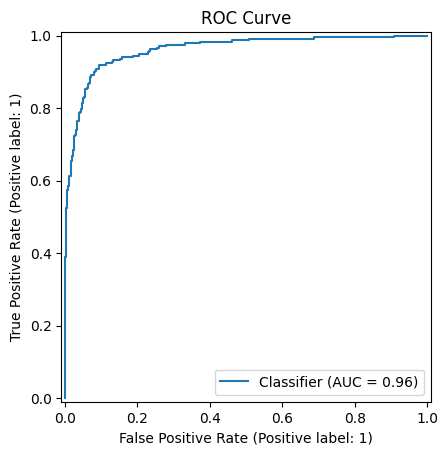

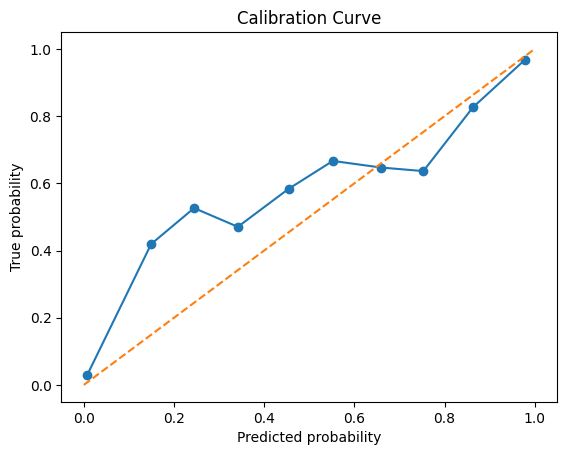

Brier score: 0.0580


In [24]:
# 7. Đánh giá trên tập test
dtest = xgb.DMatrix(X_test, enable_categorical=True)
y_pred_prob = model.predict(dtest)
y_pred = (y_pred_prob >= 0.5).astype(int)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Precision, Recall, F1
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

# ROC AUC
auc = roc_auc_score(y_test, y_pred_prob)
print(f"Test ROC AUC: {auc:.4f}")

# Vẽ ROC curve
RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.title('ROC Curve')
plt.show()

# Calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_pred_prob, n_bins=10)
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration Curve')
plt.show()

# Brier score
brier = brier_score_loss(y_test, y_pred_prob)
print(f"Brier score: {brier:.4f}")

C:\Users\CPN\AppData\Local\Temp\ipykernel_7276\3464900335.py:9: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test)


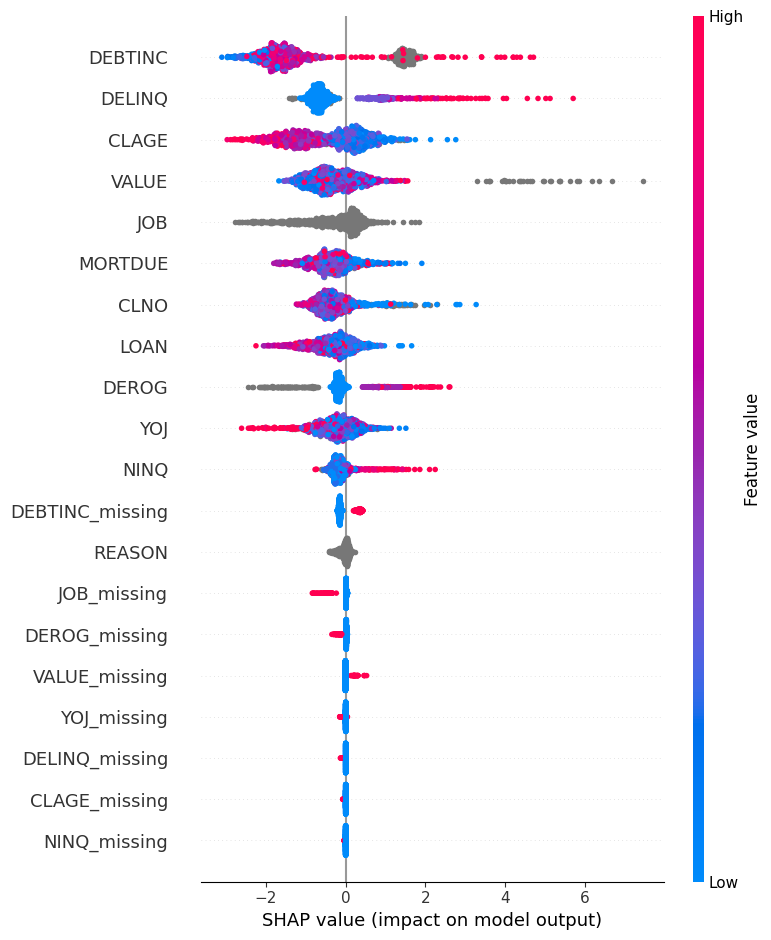

In [27]:
# 8. Tính SHAP values và hiển thị
# Chuyển X_test thành DMatrix để hỗ trợ categorical
dtest = xgb.DMatrix(X_test, enable_categorical=True)
explainer = shap.TreeExplainer(model)
# Tính SHAP trên DMatrix
shap_values = explainer.shap_values(dtest)

# Summary plot (yêu cầu môi trường hỗ trợ hiển thị đồ họa)
shap.summary_plot(shap_values, X_test)
# Có thể thêm dependence plot cho feature quan trọng nhất
# idx_max = np.argmax(np.abs(shap_values).mean(0))
# shap.dependence_plot(X_test.columns[idx_max], shap_values, X_test)

<Figure size 640x480 with 0 Axes>

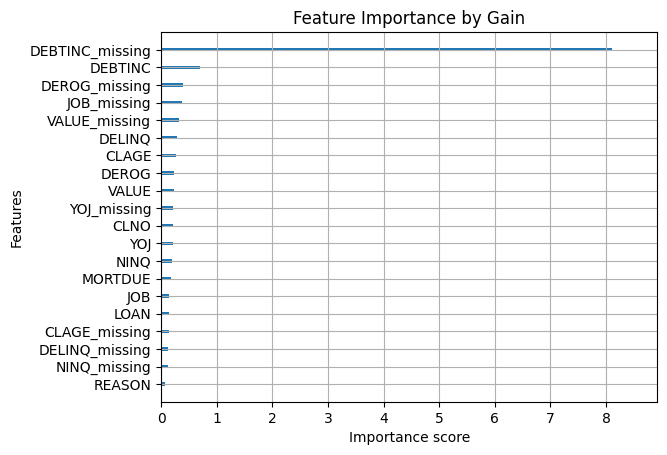

In [28]:
# 9. Feature Importance
plt.figure()
xgb.plot_importance(model, importance_type='gain', show_values=False)
plt.title('Feature Importance by Gain')
plt.show()